In [45]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder 

# Анализ данных

Датасет состоит из двух csv-таблиц: в одной содержатся данные, полученные после обработки файлов целиком (каждый обрезан до 30 секунд), другой - те же данные, но полученные из файлов, которые поделили на куски по 3 секунды.

Также в датасете есть все аудиофайлы и их визуальное представление (mel spectrogram).

Проанализируем таблицу с данными о полных аудиофайлах.

In [46]:
df = pd.read_csv('data/features_30_sec.csv')
df = df.iloc[:, 1:]
df.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [47]:
df.shape

(1000, 59)

In [48]:
df.columns

Index(['length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
       'label'

Посмотрим на корреляции столбцов со средними значениями.

<Axes: >

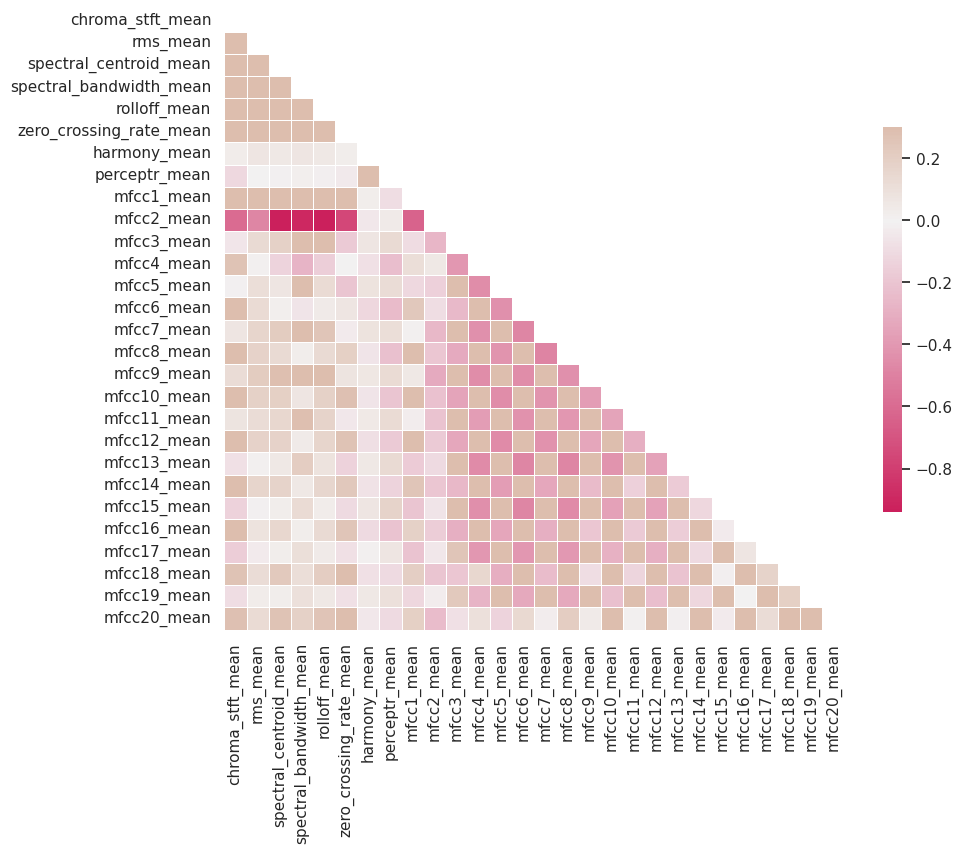

In [49]:
mean_cols = [col for col in df.columns if 'mean' in col]
corr = df[mean_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool_))
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [50]:
sns.set_theme(rc={'figure.figsize':(9.0,6.0)}, style="white")

<Axes: xlabel='label', ylabel='Count'>

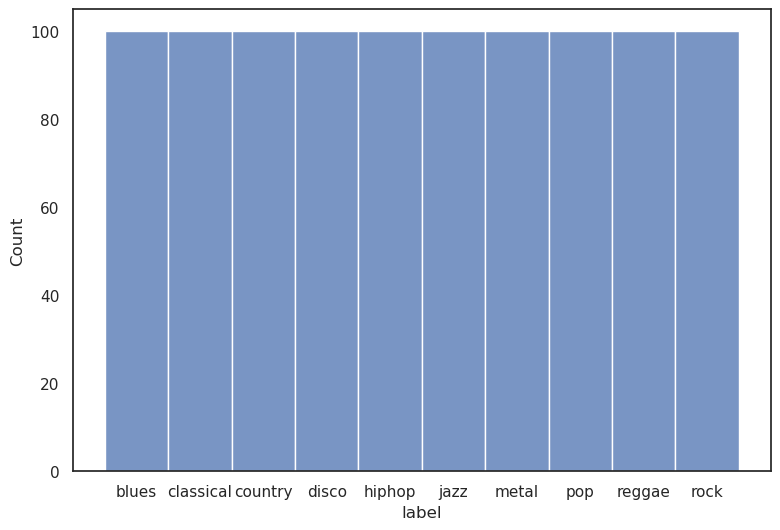

In [51]:
sns.histplot(df, x='label')

<Axes: xlabel='label', ylabel='tempo'>

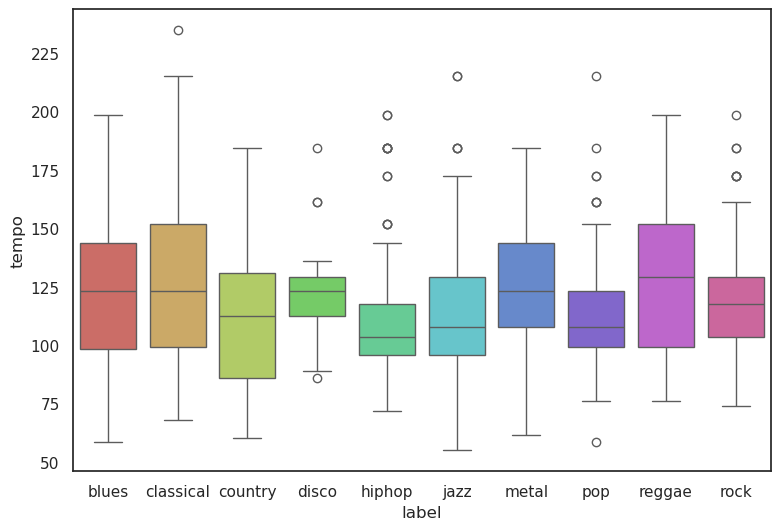

In [52]:
sns.boxplot(data=df, y='tempo', x='label', hue='label', legend=False, palette="hls")

Применим метод главных компонент, чтобы визуально оценить

In [53]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

cols = X.columns
min_max_scaler = MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, y], axis = 1)

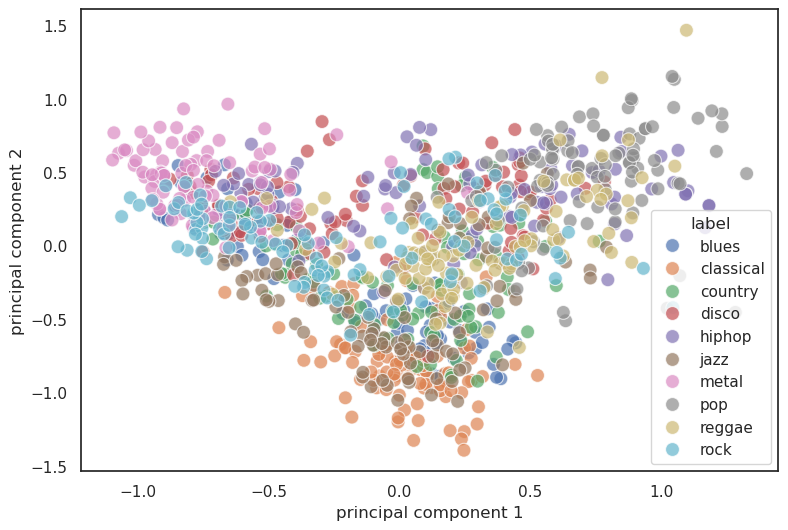

In [54]:
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

# Нормализация данных

In [56]:
df = pd.read_csv('data/features_3_sec.csv')
df = df.iloc[:, 1:]
df.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [62]:
X = df.loc[:, df.columns != 'length']
y = X.pop('label')

labelencoder= LabelEncoder()
y = labelencoder.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [63]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [71]:
import pickle
pickle.dump(scaler, open('scaler.pickle', 'wb'))

In [64]:
labelencoder.transform(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Обучение и выбор модели

In [65]:
import warnings
warnings.filterwarnings("ignore")

## Простые модели

In [66]:
fit_results = []

for model in [LogisticRegression(random_state=42), RandomForestClassifier(random_state=42), KNeighborsClassifier(), 
              CatBoostClassifier(verbose=False, random_state=42), SVC(random_state=42), XGBClassifier(random_state=42)]:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    fit_results.append(
        {
            'model': model.__class__.__name__,
            'f1': f1_score(y_pred, y_test, average='macro'),
            'balanced_accuracy': balanced_accuracy_score(y_pred, y_test)
        }
    )
fit_results = pd.DataFrame(fit_results)

In [67]:
fit_results

,model,f1,balanced_accuracy
0,LogisticRegression,0.696179,0.696691
1,RandomForestClassifier,0.852970,0.855582
2,KNeighborsClassifier,0.880298,0.882523
3,CatBoostClassifier,0.903094,0.903609
4,SVC,0.753058,0.753672
5,XGBClassifier,0.886331,0.886613


## Catboost

### Подбор гиперпараметров

In [17]:
import optuna

def objective(trial):
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "iterations": trial.suggest_int("iterations", 500, 2000),
        "objective": trial.suggest_categorical("objective", ["MultiClass", "MultiClassOneVsAll"]),
        "depth": trial.suggest_int("depth", 2, 12),
        "bootstrap_type": trial.suggest_categorical(
        "bootstrap_type", ["Bayesian", "Bernoulli"]
        ),
        "task_type": "GPU",
        "random_state":42,
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cb = CatBoostClassifier(**param)

    cb.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=0, early_stopping_rounds=50)

    preds = cb.predict(x_val)
    pred_labels = np.rint(preds)
    f1 = f1_score(y_true=y_val, y_pred=pred_labels, average='macro')
    return f1

In [18]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, timeout=5400)

[I 2024-06-03 15:51:09,643] A new study created in memory with name: no-name-a4345b57-abe5-4de0-b108-1a30eea24d8e

[I 2024-06-03 15:51:11,534] Trial 0 finished with value: 0.7630334747500244 and parameters: {'learning_rate': 0.0762986878220874, 'iterations': 523, 'objective': 'MultiClass', 'depth': 2, 'bootstrap_type': 'Bernoulli', 'subsample': 0.15970851561554483}. Best is trial 0 with value: 0.7630334747500244.

[I 2024-06-03 15:51:26,142] Trial 1 finished with value: 0.8904610466866648 and parameters: {'learning_rate': 0.07809293775294329, 'iterations': 893, 'objective': 'MultiClass', 'depth': 8, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.7190061079364582}. Best is trial 1 with value: 0.8904610466866648.

[I 2024-06-03 15:51:28,910] Trial 2 finished with value: 0.8024179151142148 and parameters: {'learning_rate': 0.04226947379625934, 'iterations': 898, 'objective': 'MultiClassOneVsAll', 'depth': 3, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8899948151995413}. Best is 

In [19]:
print("Number of finished trials: {}".format(len(study.trials)))

Number of finished trials: 117


In [20]:
study.best_trial.value

0.918618052929698

In [21]:
study.best_trial.params

{'learning_rate': 0.0976266430893863,
 'iterations': 1955,
 'objective': 'MultiClassOneVsAll',
 'depth': 8,
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.9654472554758405}

In [68]:
best_params = {'learning_rate': 0.0976266430893863,
 'iterations': 1955,
 'objective': 'MultiClassOneVsAll',
 'depth': 8,
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.9654472554758405,
 'random_state': 42}
cb_best_params = CatBoostClassifier(**best_params)
cb_best_params.fit(x_train, y_train, early_stopping_rounds=50, verbose=0)

In [69]:
pred = cb_best_params.predict(x_test)
f1_score(y_true=y_test, y_pred=pred, average='macro')

0.923114783840067

In [70]:
cb_best_params.save_model('model.pickle')

Посмотрим на важности признаков - возможно, некоторые признаки не важны и их можно удалить.

In [24]:
importances = pd.DataFrame({'feature': x_train.columns, 'catboost': cb_best_params.get_feature_importance()})
importances = importances.sort_values(by='catboost', ascending=False)
importances

,feature,catboost
15,perceptr_var,6.530572
14,perceptr_mean,5.604703
23,mfcc4_mean,4.589639
3,rms_var,4.395282
0,chroma_stft_mean,3.812019
13,harmony_var,3.793278
21,mfcc3_mean,3.177317
27,mfcc6_mean,2.868167
31,mfcc8_mean,2.686117
29,mfcc7_mean,2.681554


In [25]:
len(x_train.columns)

57

## CNN

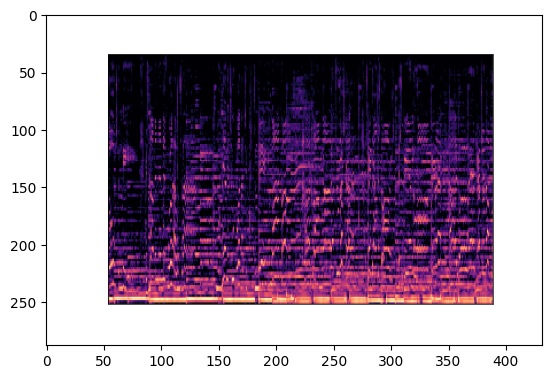

shape = (288, 432, 4)


In [122]:
import matplotlib.image as mpimg
import os

images_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/'

img = mpimg.imread(os.path.join(images_path, 'country/country00000.png'))
plt.imshow(img)
plt.show()
print('shape =',img.shape)

In [123]:
import torch
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(42)
np.random.seed(42)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data = torchvision.datasets.ImageFolder(root = images_path, transform=transform)

In [124]:
train_size = int(len(data)*0.6)
val_size = ((len(data) - train_size))//2
test_size = len(data) - train_size-val_size

In [125]:
from torch.utils.data import random_split

train_data, val_data, test_data = random_split(data, [train_size, val_size, test_size])

In [126]:
from torch.utils.data.dataloader import DataLoader

batch_size = 16
train_loader = DataLoader(train_data, batch_size, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_data, batch_size, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size, pin_memory=True, shuffle=True)

In [127]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [133]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 50)
        self.batch_norm1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 11, 20)
        self.batch_norm2 = nn.BatchNorm2d(11)
        self.conv3 = nn.Conv2d(11, 16, 8)
        self.batch_norm3 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(13104, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.batch_norm1(F.relu(self.conv1(x))))
        x = self.pool(self.batch_norm2(F.relu(self.conv2(x))))
        x = self.pool(self.batch_norm3(F.relu(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [134]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)

In [135]:
from tqdm import tqdm

def calc_acc(y_true, y_pred):
    return sum(y_true == y_pred) / len(y_true)

for epoch in range(7):
    print(f"EPOCH {epoch}")
    train_loss = []
    net.train()
    for data in tqdm(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
    
    print("EVALUATING")
    
    net.eval()
    
    true_labels = torch.Tensor().to(device)
    val_labels = torch.Tensor().to(device)
    val_loss = []
    for batch in tqdm(val_loader):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        true_labels = torch.cat((true_labels, labels))
        
        outputs = net(inputs)
        val_labels = torch.cat((val_labels, torch.max(outputs, 1)[1]))
        
        val_loss.append(criterion(outputs, labels).item())
    
    print(f'train loss: {sum(train_loss) / len(train_loss)}')
    print(f"val accuracy: {float(calc_acc(true_labels, val_labels))}")
    print(f'val loss: {sum(val_loss) / len(val_loss)}')
    
    print()

print('Finished Training')

EPOCH 0


100%|██████████| 38/38 [00:16<00:00,  2.34it/s]


EVALUATING


100%|██████████| 13/13 [00:02<00:00,  4.61it/s]


train loss: 2.3202914250524422
val accuracy: 0.1599999964237213
val loss: 2.2697822130643406

EPOCH 1


100%|██████████| 38/38 [00:16<00:00,  2.36it/s]


EVALUATING


100%|██████████| 13/13 [00:02<00:00,  4.62it/s]


train loss: 2.2202102385069193
val accuracy: 0.1599999964237213
val loss: 2.20258039694566

EPOCH 2


100%|██████████| 38/38 [00:16<00:00,  2.35it/s]


EVALUATING


100%|██████████| 13/13 [00:02<00:00,  4.63it/s]


train loss: 2.1815846029080843
val accuracy: 0.17999999225139618
val loss: 2.2244807206667385

EPOCH 3


100%|██████████| 38/38 [00:16<00:00,  2.36it/s]


EVALUATING


100%|██████████| 13/13 [00:02<00:00,  4.46it/s]


train loss: 2.1376301050186157
val accuracy: 0.07000000029802322
val loss: 7.17680417574369

EPOCH 4


100%|██████████| 38/38 [00:16<00:00,  2.36it/s]


EVALUATING


100%|██████████| 13/13 [00:02<00:00,  4.60it/s]


train loss: 2.1164167931205347
val accuracy: 0.13499999046325684
val loss: 5.480211221254789

EPOCH 5


100%|██████████| 38/38 [00:16<00:00,  2.35it/s]


EVALUATING


100%|██████████| 13/13 [00:02<00:00,  4.60it/s]


train loss: 2.0501076579093933
val accuracy: 0.20999999344348907
val loss: 2.170289864906898

EPOCH 6


100%|██████████| 38/38 [00:16<00:00,  2.37it/s]


EVALUATING


100%|██████████| 13/13 [00:02<00:00,  4.54it/s]

train loss: 1.9998346661266528
val accuracy: 0.25
val loss: 2.066162421153142

Finished Training


In [136]:
net.eval()
    
true_labels = []
val_labels = []
for batch in tqdm(test_loader):
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    true_labels += list(map(lambda x: float(x), list(labels)))

    outputs = net(inputs)
    val_labels += list(map(lambda x: float(x), list(torch.max(outputs, 1)[1])))

100%|██████████| 13/13 [00:02<00:00,  4.55it/s]


In [137]:
f1_score(true_labels, val_labels, average='macro')

0.1954713804713805